Want to compare WOM to FOE using chebyshev polynomials

In [1]:
import numpy as np
from numba import njit
from scipy import sparse, linalg
from scipy.io import mmread, mmwrite
from adaptive_step_dmm import CAdaptiveDMM
from adaptive_step_DMM_sqrt import CAdaptiveDMMsqrt
from adaptive_C import CAdaptive_C_RK4
from adaptive_C_sqrt import CAdaptive_C_RK4_sqrt
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression

In [2]:
def get_chebyshev(H, I, N):
    n = 2
    T = [I, H]
    while n < N+1:
        T_n = 2 * H @ T[n-1] - T[n-2]
        T.append(T_n)
        n += 1
    
    return T

In [3]:
def calc_ρ(coeffs, chebys):
    ρ = coeffs[0] / 2 * chebys[0]
    for i in range(1, coeffs.size):
        ρ += coeffs[i] * chebys[i]
        
    return ρ

In [4]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
# Define path for matrices
matrices_path = "larger_matrices/"

In [6]:
# Load matrices
H_16 = mmread(matrices_path + "16_H.mtx").toarray()
S_16 = mmread(matrices_path + "16_S.mtx").toarray()

# Save other parameters
E_16, V_16 = linalg.eigh(H_16, S_16)

# Define num_electrons and beta
num_electrons = 3*16
nel = 16
β = 10
dβ = 0.1
inv_S = linalg.inv(S_16)
inv_sqrt_S = linalg.sqrtm(inv_S)

## Fermi Operator Expansion

In [7]:
# Scale H so that eigenvalues lie between -1 and 1
σ = 2 / (E_16[-1] - E_16[0])
τ = (E_16[-1] + E_16[0]) / 2
I = np.eye(H_16.shape[0], dtype=complex)
H = σ*(H_16 - τ * I)
E_16, V_16 = linalg.eigh(H_16, S_16)

In [8]:
# Get energy array
ϵ = np.linspace(-1, 1, H_16.shape[0])

# Define first guess for μ as middle
μ = ϵ[int(nel / 2) - 1] + 0.5  * (ϵ[int(nel / 2)] - ϵ[int(nel / 2) - 1])

In [9]:
# Get an estimate for the minimum degree needed
d = 0
f = 1 / (1 + np.exp(β * (ϵ - μ)))
p = np.polynomial.chebyshev.Chebyshev.fit(ϵ, f, d)
err = np.abs(f - p.linspace(H_16.shape[0])[1])
while np.any(err > 1e-6):
    d += 1
    p = np.polynomial.chebyshev.Chebyshev.fit(ϵ, f, d)
    err = np.abs(f - p.linspace(H_16.shape[0])[1])

In [10]:
# Create Chebyshev polynomials of degree d
T = get_chebyshev(inv_sqrt_S @ H @ inv_sqrt_S, I, d)

In [11]:
# Evaluate 1D f(ϵ) and use numpy to get coefficients of series
f = 1 / (1 + np.exp(β * (ϵ - μ)))
cheby = np.polynomial.chebyshev.Chebyshev.fit(ϵ, f, d)

In [12]:
# Use coefficients and T to calculate ρ
left = ϵ[0]
right = ϵ[-1]
μ2s = []
ρ = calc_ρ(cheby.coef, T)
while abs(np.trace(S_16 @ ρ) - int(num_electrons / 2)) > 1e-6:
    μ2 = left  + 0.5*(right - left)
    μ2s.append(μ2)
    f = 1 / (1 + np.exp(β * (ϵ - μ2)))
    cheby = np.polynomial.chebyshev.Chebyshev.fit(ϵ, f, d)
    ρ = inv_sqrt_S @ calc_ρ(cheby.coef, T) @ inv_sqrt_S
    if np.trace(S_16 @ ρ) > int(num_electrons / 2):
        right = μ2
    else:
        left = μ2
        
    print(left, right)
    if abs(left - right) < 1e-6:
        break

-1.0 0.0
-0.5 0.0
-0.25 0.0
-0.125 0.0
-0.0625 0.0
-0.0625 -0.03125
-0.046875 -0.03125
-0.046875 -0.0390625
-0.04296875 -0.0390625
-0.04296875 -0.041015625
-0.04296875 -0.0419921875
-0.04248046875 -0.0419921875
-0.04248046875 -0.042236328125
-0.04248046875 -0.0423583984375
-0.04248046875 -0.04241943359375
-0.04248046875 -0.042449951171875
-0.04248046875 -0.0424652099609375
-0.04248046875 -0.04247283935546875
-0.042476654052734375 -0.04247283935546875
-0.042476654052734375 -0.04247474670410156
-0.04247570037841797 -0.04247474670410156


In [13]:
np.trace(2 * S_16 @ ρ)

(47.9999659693859+0j)

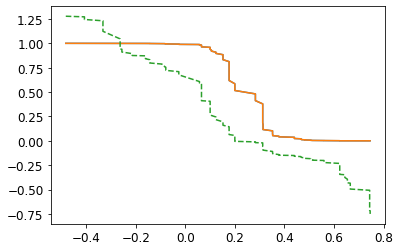

In [21]:
plt.plot(E_16, f)
plt.plot(E_16, cheby.linspace(H_16.shape[0])[1])
plt.plot(E_16, linalg.eigvalsh(S_16 @ ρ)[::-1], '--')

In [23]:
np.sum(linalg.eigvalsh(S_16 @ ρ))

1.836025724379759

In [16]:
fs = []
for u in μ2s:
    fs.append(1 / (1 + np.exp(β * (ϵ - u))))

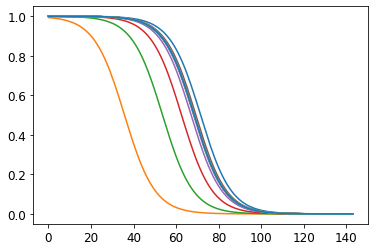

In [17]:
for _ in fs:
    plt.plot(_)

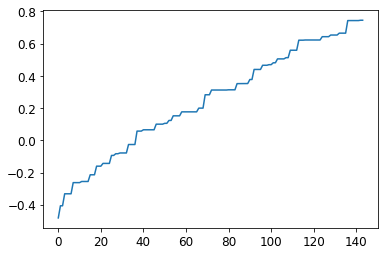

In [18]:
plt.plot(E_16)